In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   scipy.stats import norm
from   scipy.special import logsumexp
from   matplotlib.colors import LogNorm

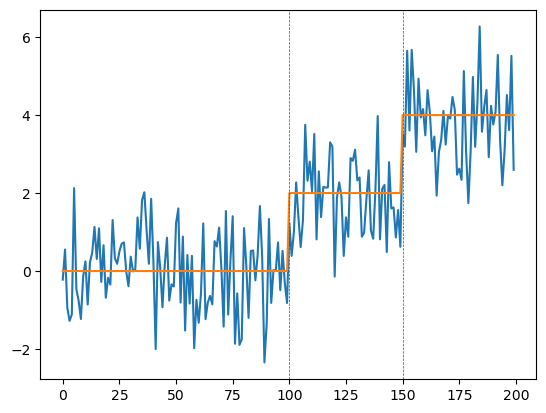

In [128]:
## Generating data with change in mean

sigma_noise = 1

a = np.ones((100,)) * 0
b = np.ones((50,)) * 2
c = np.ones((50,)) * 4

means = np.concatenate([a,b,c], axis = 0)
signal_means = np.concatenate([a,b,c], axis = 0) + sigma_noise * np.random.randn(200,)

plt.plot(signal_means)
plt.plot(means)
plt.axvline(x = 100, linestyle = "dashed", c = 'r', linewidth = 0.5)
plt.axvline(x = 150, linestyle = "dashed", c = 'r', linewidth = 0.5)



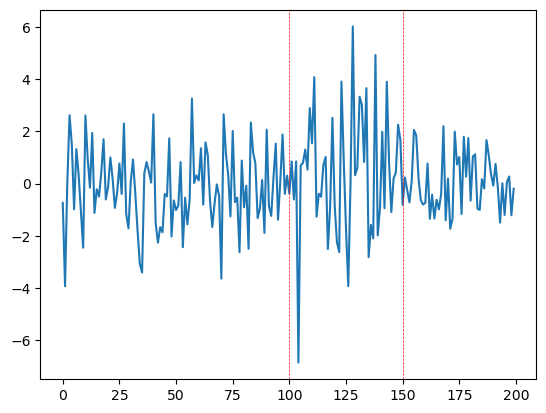

In [123]:
## Generating data with change in variance

sigma_noise = 1

a = 1.5*sigma_noise * np.random.randn(100,)
b = 2.5*sigma_noise * np.random.randn(50,)
c = sigma_noise * np.random.randn(50,)

signal_var = np.concatenate([a, b, c], axis = 0)

plt.plot(signal_var)

plt.axvline(x = 100, linestyle = "dashed", c = 'r', linewidth = 0.5)
plt.axvline(x = 150, linestyle = "dashed", c = 'r', linewidth = 0.5)

#### Assumptions

- Constant change point prior
- Gaussian prior to the mean 
- constant variance

In [129]:
# Initialisation

hazard = 1/100
mean0 = 0
var0 = 2

T = len(signal_means)
log_R = -np.inf * np.ones((T+1, T+1)) # Run length posterior log-probability matrix
log_R[0, 0] = 0 # At time 0, the posterior proability is initialised to 1 at R = 0

predictive_mean = np.nan * np.empty(T) # Mean of the predictive distribution of the next data point
predictive_variance = np.nan * np.empty(T) # Variance of the predictive distribution of the next data point

log_message = np.array([0]) # message initialised at 1
log_H = np.log(hazard) # Constant prior on changepoint probability.
log_1_minus_H = np.log(1-hazard)

# Prior's parameters for the previous data point

prior_mean = np.array([mean0])
prior_variance = np.array([var0]) 

# def var_params(precision, sigma_squared = sigma_noise**2):
#         return 1./precision + sigma_squared

In [130]:
# Online posterior distribution of the run length update:

for t in range(1, T+1):
    x = signal_means[t-1] # Reading the new data point

    # Predictions for the next data point
    predictive_mean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * prior_mean[:t])
    predictive_variance[t-1] = np.sum(np.exp(log_R[t-1, :t]) * (prior_variance[:t] + sigma_noise**2))

    # Posterior predictive probabilitu=ies for each run length
    log_pis = norm(prior_mean[:t], np.sqrt(prior_variance[:t]+ sigma_noise**2)).logpdf(x)
    
    # Growth probability
    log_growth_probs = log_pis + log_message + log_1_minus_H

    # Changepoint probability
    log_cp_prob = logsumexp(log_pis + log_message + log_H)

    # Computing the evidence
    new_log_joint  = np.append(log_cp_prob, log_growth_probs)

    # Updating the run length distribution at time t
    log_R[t, :t+1]  = new_log_joint
    log_R[t, :t+1] -= logsumexp(new_log_joint)

    # Updating the prior parameters for the next step
    prior_variance_new = 1/(1/prior_variance + sigma_noise**2)
    prior_variance = np.append([var0], prior_variance_new)

    prior_mean = np.append([mean0], (prior_mean / prior_variance[:-1] + x/(sigma_noise**2))*prior_variance_new)
    prior_prvariance = prior_variance_new
    
    # Pass message
    log_message = new_log_joint



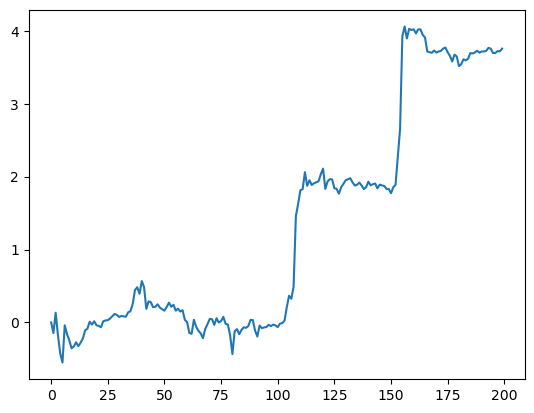

In [131]:
plt.plot(predictive_mean)

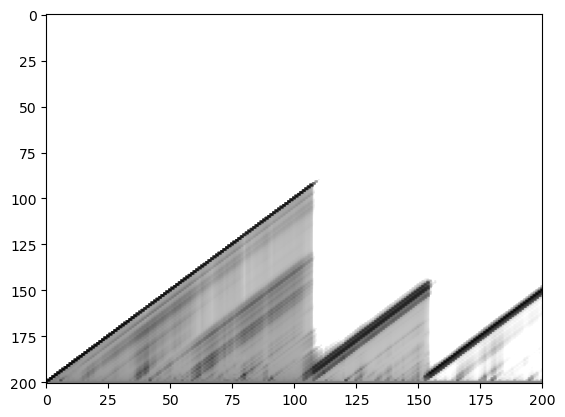

In [132]:
plt.imshow(np.rot90(np.exp(log_R)), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
plt.xlim([0, T])
plt.margins(0)